In [3]:
! pip install siphon seaborn >/dev/null

  Using cached https://files.pythonhosted.org/packages/56/f5/2be03af9ac2911d4795ac69de86dbd1b48c404a7812a4bf1b00403eafda5/siphon-0.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from siphon.catalog import TDSCatalog
import seaborn as sns
sns.set(style='white')
import numpy as np

import xesmf as xe
from geopandas import GeoDataFrame

from random import sample

import xarray as xr
from dask.distributed import Client
import gcsfs

PNW_LAT = slice(1.52, 63.4)
PNW_LON =slice(-170, -103)

%config InlineBackend.figure_formats = ['png']
%matplotlib inline 

In [2]:
client = Client()

In [3]:
client.cluster.scale(4)

# [AquaMaps](http://www.aquamaps.org) vs GlobTherm Thermal Tolerances?

*Tony Cannistra, January 2020*

It would be nice to see how much thermal tolerances are actually encountered across observed species' ranges. We'll use the range maps from [AquaMaps.org](http://www.aquamaps.org), thermal tolerances from the [GlobalTherm](https://datadryad.org/stash/dataset/doi:10.5061/dryad.1cv08) dataset, and SST from OISST? 

## Thermal Tolerance Data

In [4]:
globtherm = pd.read_csv("../../data/globtherm/GlobalTherm_upload_02_11_17.csv", engine='python')

In [5]:
globtherm.head()

,Genus,Species,N,Tmax,max_metric,error,error measure,Multiple measures,max_interval_after_LT0,Tmax_2,...,lat_min,long_min,elevation_min,REF_min,location_min,Phylum,Class,Order,Family,Quality of UTNZ
0,Prochilodus,scrofa,10.0,35.7,ctmax,NaN,NaN,N,NaN,NaN,...,-22.0,-43.50,0.0,Barrionuevo_&_Fernandes_1995,2.0,Chordata,Actinopteri,Characiformes,Prochilodontidae,NaN
1,Lepomis,gibbosus,24.0,35.1,ctmax,NaN,NaN,Y,NaN,NaN,...,46.2,-119.00,NaN,Becker_et_al_1977,1.0,Chordata,Actinopteri,Perciformes,Centrarchidae,NaN
2,Cyprinodon,variegatus,100.0,44.2,ctmax,0.29,SD,Y,NaN,NaN,...,26.0,-97.15,0.0,Bennett_&_Beitinger_1997,1.0,Chordata,Actinopteri,Cyprinodontiformes,Cyprinodontidae,NaN
3,Oncorhynchus,keta,NaN,23.2,LT50,NaN,NaN,N,NaN,NaN,...,52.0,-128.90,0.0,Brett&Alderdice1958_in_Brett_1970,1.0,Chordata,Actinopteri,Salmoniformes,Salmonidae,NaN
4,Oncorhynchus,nerka,NaN,21.5,LT50,NaN,NaN,N,NaN,NaN,...,52.0,-128.90,0.0,Brett&Alderdice1958_in_Brett_1970,1.0,Chordata,Actinopteri,Salmoniformes,Salmonidae,NaN


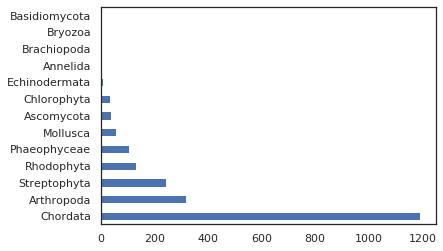

In [6]:
globtherm.Phylum.value_counts().plot(kind='barh')

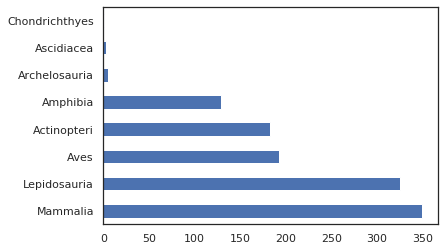

In [33]:
globtherm[globtherm.Phylum == "Chordata"].Class.value_counts().plot(kind='barh')

### Examine the dataset a little bit

Text(0.5, 1.0, '$CT_{max}$ Metric Types, Whole Dataset')

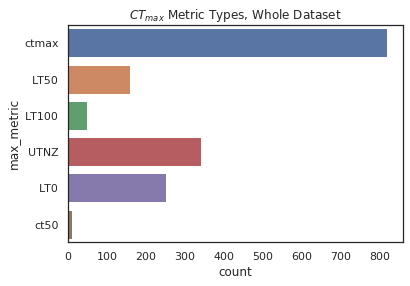

In [8]:
sns.countplot(data=globtherm, y='max_metric')
plt.title("$CT_{max}$ Metric Types, Whole Dataset")

### Max_Metric Types by Class

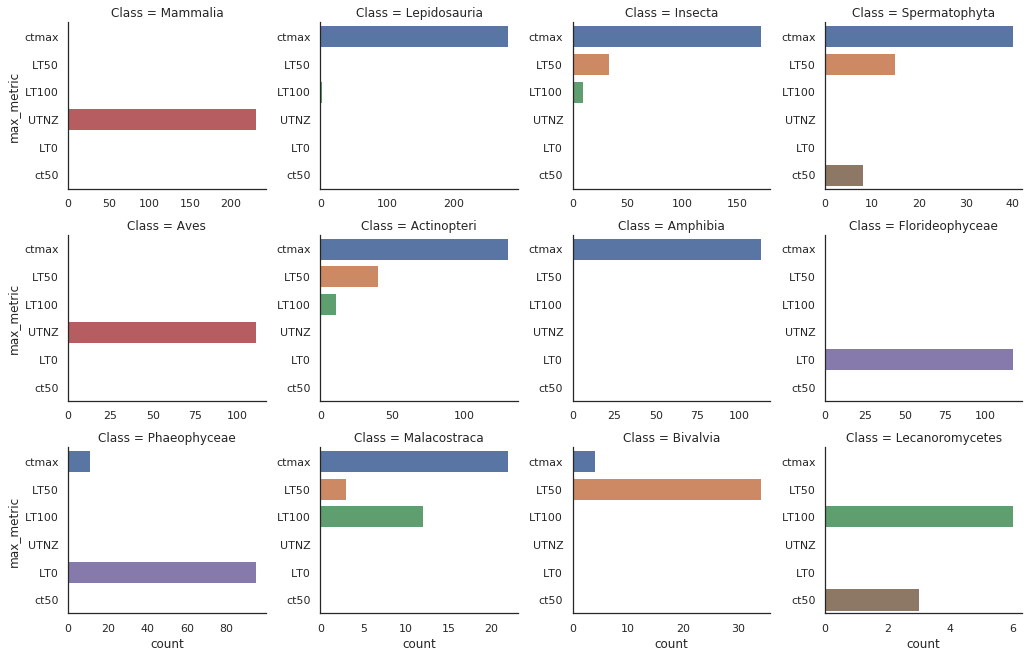

In [126]:
sns.catplot(col = 'Class', y = 'max_metric', 
            kind='count', col_wrap=4, col_order = globtherm.Class.value_counts().index[:12],
            sharex=False, sharey=False, 
            data = globtherm,height=3, aspect=1.2)

### Max_Metric Types of Fishes (*Actinopterygii*) by Order
Listed as out-of-date name "*Actinopteri*" in GlobTherm.


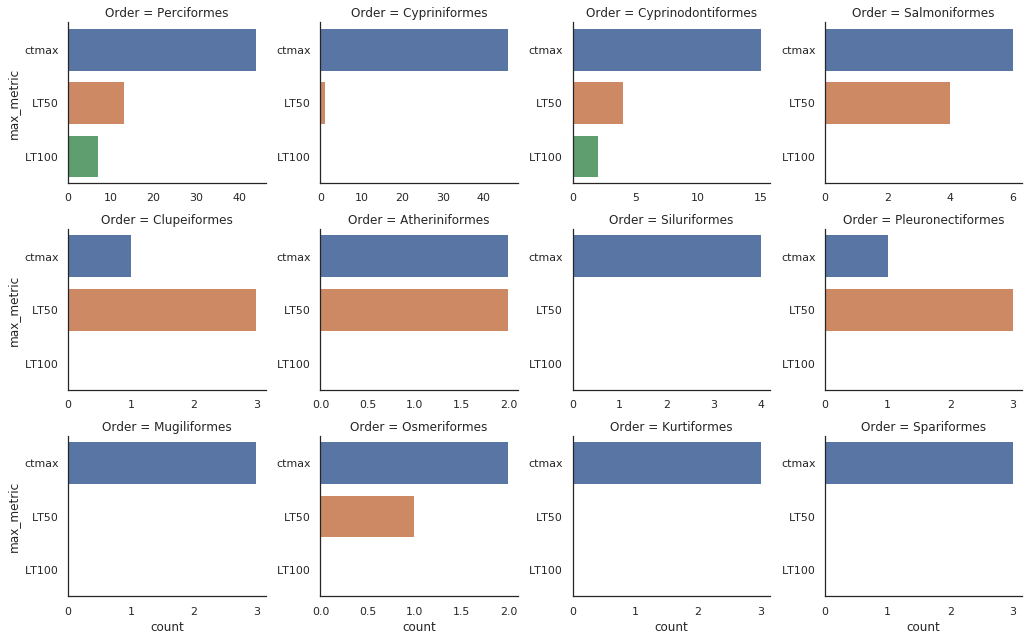

In [127]:
fishes = globtherm.query("Class == 'Actinopteri'")
g = sns.catplot(col="Order", y='max_metric',
               kind = 'count', col_wrap=4,
               sharex = False, sharey=False,
               col_order = fishes.Order.value_counts().index[:12],
               data = fishes, height=3, aspect=1.2)


plt.tight_layout()

### Number of Species in each Order

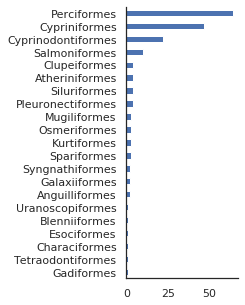

In [242]:
fig = plt.figure(figsize=(2, 5))
fishes.Order.value_counts(ascending=True).plot(kind='barh')
sns.despine()

## GlobalTherm Overlap with AquaMaps

In [7]:
AQUAMAPS_THREDDS = "https://thredds.d4science.org/thredds/catalog/public/netcdf/AquamapsNative/catalog.xml"
AQUAMAPS_FILE_TEMPLATE = "aquamaps_native_{}.nc"
aqmapsCatalog = TDSCatalog(AQUAMAPS_THREDDS)
datasets = aqmapsCatalog.datasets

In [8]:
genus_species_tuples = [tuple(d.split(".")[0].split('_')[2:]) for d in datasets]
tuple_lengths = np.array([len(i) for i in genus_species_tuples])
# deal with species w subspecies + other wierd cases
# genus_species_tuples = np.array([len(i) for i in genus_species_tuples])

genus_species_tuples = np.array([(i[0], "_".join(i[1:])) if len(i) == 3 else i for i in genus_species_tuples])
genus_species_tuples = genus_species_tuples[~(tuple_lengths < 2)]
genus_species_tuples

array([('abalistes', 'stellaris'), ('abalistes', 'stellatus'),
       ('abietinella', 'operculata'), ..., ('zoramia', 'viridiventer'),
       ('zosterisessor', 'ophiocephalus'), ('zu', 'elongatus')],
      dtype=object)

In [9]:
genus,species = list(zip(*genus_species_tuples))


In [10]:
aq_species = pd.DataFrame(data=np.array([genus, species]).T, columns=['genus', 'species'])

In [11]:
globtherm_overlap = globtherm.merge(aq_species,
                                    left_on = [globtherm.Genus.str.lower(), globtherm.Species.str.lower()],
                                    right_on = [aq_species.genus, aq_species.species])

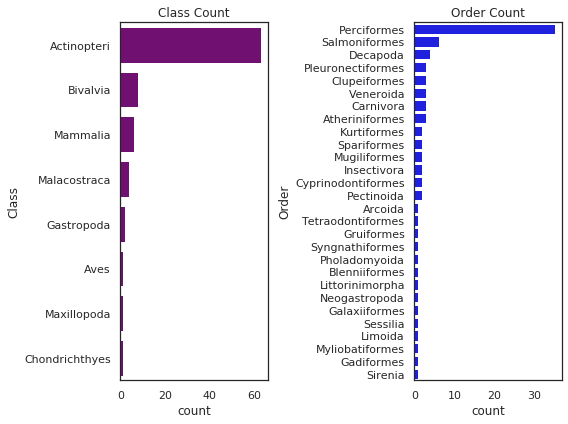

In [12]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(8,6))

sns.countplot(y='Class', data=globtherm_overlap, order = globtherm_overlap.Class.value_counts().index, color='purple', ax=axes[0])
axes[0].set_title("Class Count")
sns.countplot(y='Order', data=globtherm_overlap, order = globtherm_overlap.Order.value_counts().index, color='blue', ax=axes[1])
axes[1].set_title("Order Count")

plt.tight_layout()

## Get a few random *Actinopterygii* and plot their ranges

In [13]:
overlap_fishes = globtherm_overlap[globtherm_overlap.Class == "Actinopteri"]

In [14]:
overlap_filenames = [AQUAMAPS_FILE_TEMPLATE.format("_".join(i)) 
                     for i in list(zip(overlap_fishes.Genus.str.lower(), overlap_fishes.Species.str.lower()))]

In [15]:
random_fishes = overlap_filenames
random_fishes_urls = [datasets.get(i).access_urls['OPENDAP'] for i in random_fishes]
aquamaps = xr.open_mfdataset(random_fishes_urls, combine='nested', concat_dim='species', parallel = True)

In [17]:
aquamaps = aquamaps.assign_coords({'species': ["_".join(rf.split("_")[2:]) for rf in random_fishes]})
aquamaps = aquamaps.rename({'latitude': "lat", 'longitude': 'lon'})

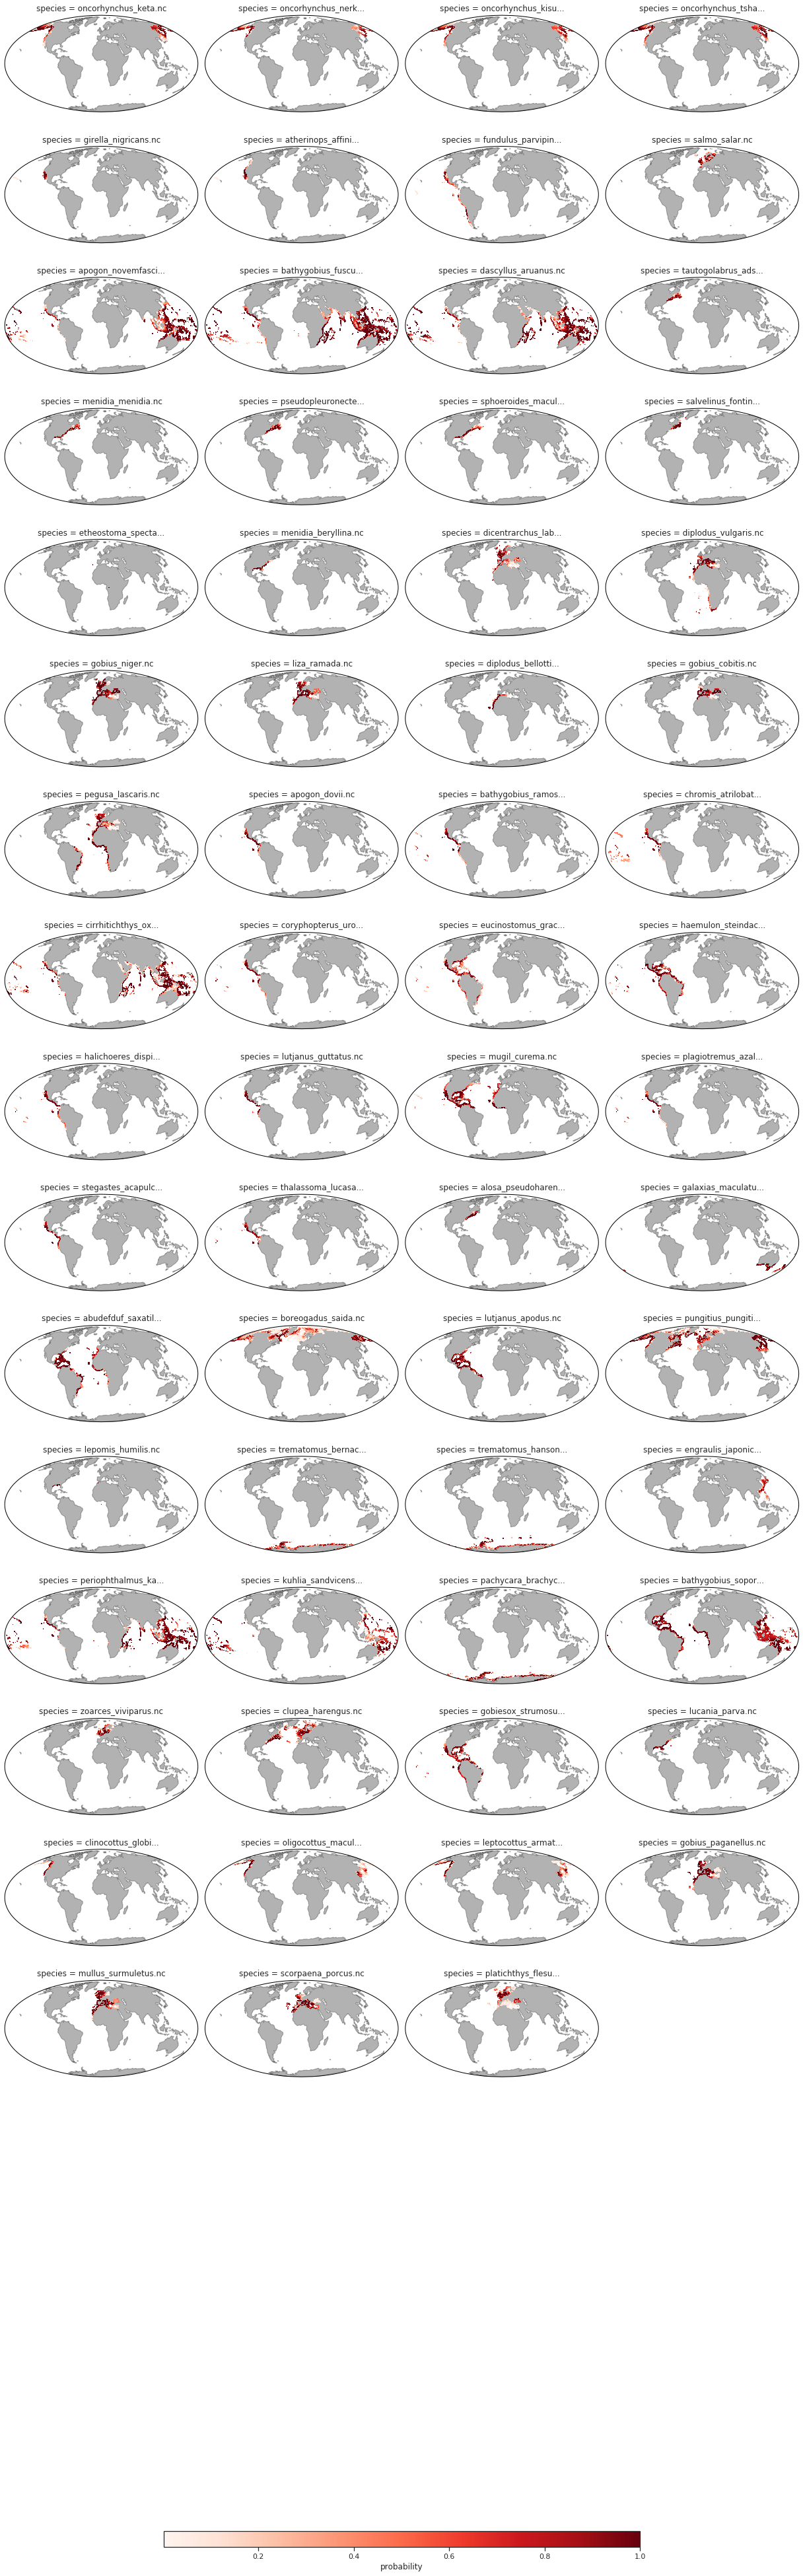

In [18]:
# PNW = aquamaps.sel(latitude = PNW_LAT, longitude= PNW_LON)
p = aquamaps.probability.plot(transform=ccrs.PlateCarree(),
                           x = 'lon', y = 'lat', col='species',
                           size=4, cmap='Reds',
                           col_wrap = 4, subplot_kws={'projection': ccrs.Mollweide()}, 
                           cbar_kwargs=dict(orientation='horizontal',aspect=30, shrink=0.6))

for ax in p.axes.flat:
    ax.add_feature(cf.LAND, color='black', alpha=0.3)
#     ax.set_extent([-170, -103, 1.52, 63.4], crs=ccrs.PlateCarree())


## Compare Ranges with SST via OISST dataset. 

We load this dataset from a GCP bucket (`gs://oisst/oisst.zarr`)

In [19]:
gcp_project_id = '170771369993'
fs = gcsfs.GCSFileSystem(project=gcp_project_id, token="/home/jovyan/gc-pangeo-storage.json")

In [20]:
oisst = xr.open_zarr(fs.get_mapper('oisst/oisst.zarr'))
# reproject oisst into actual longitudes
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

In [21]:
sst_yearly_max = oisst.sel(lat=PNW_LAT, lon=PNW_LON).sst.groupby('time.year').max(dim='time')
sst_yearly_max

<xarray.DataArray 'sst' (year: 38, lat: 248, lon: 268)>
dask.array<transpose, shape=(38, 248, 268), dtype=float32, chunksize=(1, 50, 240), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 1.625 1.875 2.125 2.375 ... 62.875 63.125 63.375
  * lon      (lon) float32 -169.875 -169.625 -169.375 ... -103.375 -103.125
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2014 2015 2016 2017 2018

In [22]:
sst_mean_yearly_max = sst_yearly_max.mean(dim='year')

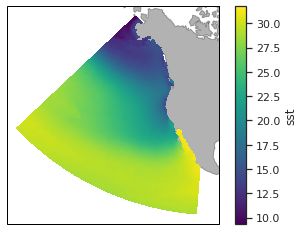

In [19]:
ax = plt.axes(projection=ccrs.LambertConformal())
ax.add_feature(cf.LAND, color='black', alpha=0.3)

sst_mean_yearly_max.plot(ax=ax, transform=ccrs.PlateCarree())


In [23]:
# Slice OISST data 
oisst_pnw = oisst.sel(lat=PNW_LAT, lon=PNW_LON)

In [24]:
# Regrid and Slice Aquamaps
aquamaps = aquamaps.interp_like(oisst)
aquamaps_pnw = aquamaps.sel(lat=PNW_LAT, lon=PNW_LON)

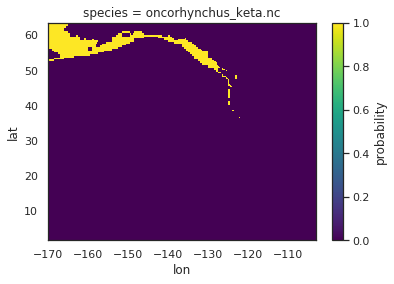

In [25]:
# Test probability mask 
test_probmask = (aquamaps_pnw.isel(species=0).probability > 0.4)
test_probmask.plot()

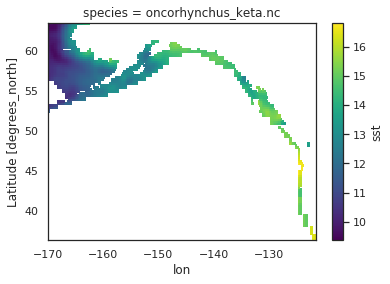

In [35]:
# Get SST over species range (large OISST dask computation, ~35 seconds)
sst_mean_yearly_max.where(test_probmask, drop=True).plot()

### How often does SST exceed $CT_{max}$ for these species?

TODO: loop through all species with range in study area and count the number of times temperature is near or greater than CTmax

In [26]:
PRESENCE_PROB_THRESH = 0.4

In [30]:
client.cluster.scale(5)

Gobius niger, 34.1C [ctmax]
Species Gobius niger does not have range in study area, skipping.
Liza ramada, 38.0C [ctmax]
Species Liza ramada does not have range in study area, skipping.
Diplodus bellottii, 27.38C [ctmax]
Species Diplodus bellottii does not have range in study area, skipping.
Gobius cobitis, 33.7C [ctmax]
Species Gobius cobitis does not have range in study area, skipping.
Pegusa lascaris, 32.9C [ctmax]
Species Pegusa lascaris does not have range in study area, skipping.
Apogon dovii, 35.9C [ctmax]


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


Bathygobius ramosus, 39.6C [ctmax]


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


Chromis atrilobata, 35.2C [ctmax]


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


ValueError: array not found at path 'sst'

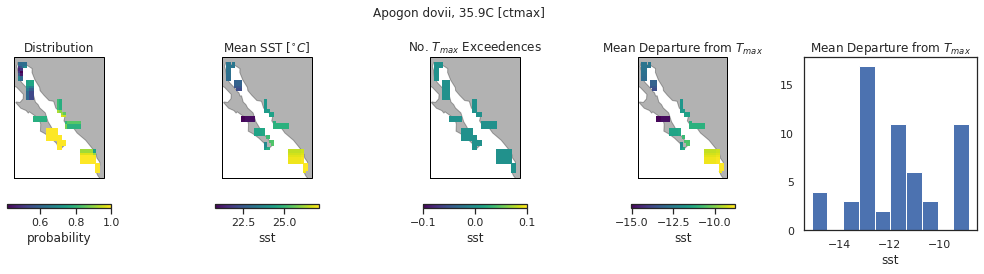

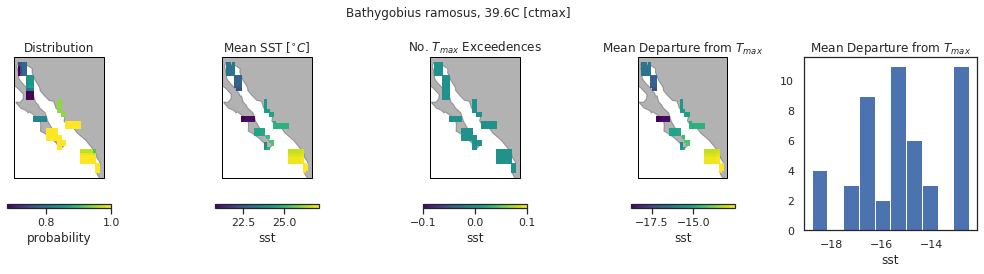

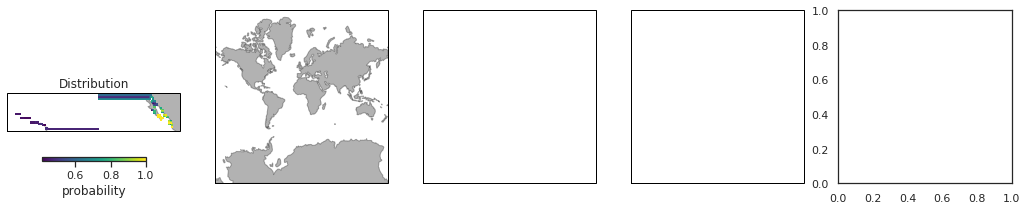

In [34]:
for i, species in list(overlap_fishes.iterrows())[20:30]:
    genus_species = (species.Genus, species.Species)
    
    # check for CTmax
    if not species.max_metric in ['ctmax', 'LT50', 'LT100']:
        # skip if not 
        print("Species {} {} has metric {}, skipping.".format(*genus_species, species.max_metric))
        continue
    print("{} {}, {}C [{}]".format(*genus_species, species.Tmax, species.max_metric))
    
    # compute binary range mask 
    range_mask = aquamaps_pnw.isel(species=i).probability >= PRESENCE_PROB_THRESH
    
    # check for range in study area
    has_pnw_range = range_mask.any()
    if not has_pnw_range:
        print("Species {} {} does not have range in study area, skipping.".format(*genus_species))
        continue
        
    # clip SST data to range 
    oisst_range = oisst_pnw.where(range_mask, drop=True)
    
    # Tmax Exceedence Count per grid cell over time
    exceedences = (oisst_range.sst >= species.Tmax).sum(dim='time').where(range_mask, drop=True) 
    
    # Average departure from Tmax across time
    monthly_departures = (oisst_range.sst - species.Tmax).mean('time')
    
    # Plotting
#     fig, axes = plt.subplots(1, 4, subplot_kw={'projection' : ccrs.Mercator().GOOGLE}, figsize=(15, 5))
    fig = plt.figure(figsize=(18,7))
    axes = [
        plt.subplot(251, projection=ccrs.Mercator().GOOGLE),
        plt.subplot(252, projection=ccrs.Mercator().GOOGLE),
        plt.subplot(253, projection=ccrs.Mercator().GOOGLE), 
        plt.subplot(254, projection=ccrs.Mercator().GOOGLE), 
        plt.subplot(255)
    ]
    
    #range 
    axes[0].add_feature(cf.LAND, color='black', alpha=0.3)
    aquamaps_pnw.isel(species=i).probability.where(range_mask, drop=True).plot(ax=axes[0],
                                                                               transform=ccrs.PlateCarree(), 
                                                                               cbar_kwargs=dict(orientation='horizontal',aspect=30, shrink=0.6))
    axes[0].set_title("Distribution")
    
    #sst
    axes[1].add_feature(cf.LAND, color='black', alpha=0.3)
    oisst_range.sst.mean(dim='time').plot(ax=axes[1], 
                                          transform=ccrs.PlateCarree(),
                                          cbar_kwargs=dict(orientation='horizontal',aspect=30, shrink=0.6))
    axes[1].set_title("Mean SST [$^{\circ}C$]")
    
    
    # exceedences
    axes[2].add_feature(cf.LAND, color='black', alpha=0.3)
    exceedences.plot(ax=axes[2],
                     transform=ccrs.PlateCarree(),
                     cbar_kwargs=dict(orientation='horizontal',aspect=30, shrink=0.6))
    axes[2].set_title("No. $T_{max}$ Exceedences")

    ## departure from sstmax
    axes[3].add_feature(cf.LAND, color='black', alpha=0.3)
    monthly_departures.plot(ax=axes[3], 
                            transform=ccrs.PlateCarree(),
                            cbar_kwargs=dict(orientation='horizontal',aspect=30, shrink=0.6))
    axes[3].set_title("Mean Departure from $T_{max}$")

    # histogram
    monthly_departures.plot.hist(ax=axes[4])
    axes[4].set_title("Mean Departure from $T_{max}$")

    
    
    plt.suptitle("{} {}, {}C [{}]".format(*genus_species, species.Tmax, species.max_metric))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.savefig("{}_{}_{}.png".format(*genus_species, species.max_metric))
    

        
    

In [ ]:
aquamaps_pnw.sel(species='apogon_dovii.nc').probability.plot()

In [51]:
aquamaps.species

<xarray.DataArray 'species' (species: 63)>
array(['oncorhynchus_keta.nc', 'oncorhynchus_nerka.nc',
       'oncorhynchus_kisutch.nc', 'oncorhynchus_tshawytscha.nc',
       'girella_nigricans.nc', 'atherinops_affinis.nc',
       'fundulus_parvipinnis.nc', 'salmo_salar.nc', 'apogon_novemfasciatus.nc',
       'bathygobius_fuscus.nc', 'dascyllus_aruanus.nc',
       'tautogolabrus_adspersus.nc', 'menidia_menidia.nc',
       'pseudopleuronectes_americanus.nc', 'sphoeroides_maculatus.nc',
       'salvelinus_fontinalis.nc', 'etheostoma_spectabile.nc',
       'menidia_beryllina.nc', 'dicentrarchus_labrax.nc',
       'diplodus_vulgaris.nc', 'gobius_niger.nc', 'liza_ramada.nc',
       'diplodus_bellottii.nc', 'gobius_cobitis.nc', 'pegusa_lascaris.nc',
       'apogon_dovii.nc', 'bathygobius_ramosus.nc', 'chromis_atrilobata.nc',
       'cirrhitichthys_oxycephalus.nc', 'coryphopterus_urospilus.nc',
       'eucinostomus_gracilis.nc', 'haemulon_steindachneri.nc',
       'halichoeres_dispilus.nc', 'lutj

In [27]:
# exceedence counts
# species
testspec = aquamaps.isel(species=6)
specdata = overlap_fishes.iloc[6]
specrange = testspec.probability >= PRESENCE_PROB_THRESH
#stack 
grid = oisst_pnw.where(specrange, drop=True).stack(cell=['lon', 'lat'])
exceedences = (grid.sst >= specdata.Tmax).groupby('cell').sum(dim='time')

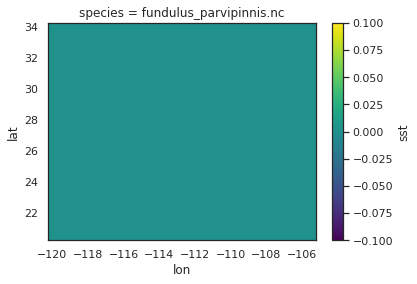

In [28]:
exceedences.unstack('cell').T.plot()

In [30]:
exceedences.unstack('cell')

<xarray.DataArray 'sst' (lon: 22, lat: 26)>
dask.array<reshape, shape=(22, 26), dtype=int64, chunksize=(1, 26), chunktype=numpy.ndarray>
Coordinates:
    species  <U32 'fundulus_parvipinnis.nc'
  * lon      (lon) float64 -120.1 -119.9 -118.6 -118.4 ... -105.9 -105.6 -105.4
  * lat      (lat) float64 20.38 20.62 21.88 22.12 ... 33.38 33.62 33.88 34.12

In [119]:
exceedences = exceedences.unstack('cell').compute()

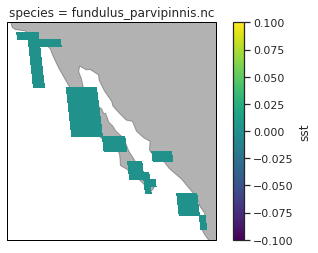

In [120]:
ax = plt.axes(projection=ccrs.Mollweide(central_longitude=-140))
ax.add_feature(cf.LAND, color='black', alpha=0.3)
exceedences.where(specrange, drop=True).T.plot(ax=ax, transform=ccrs.PlateCarree())

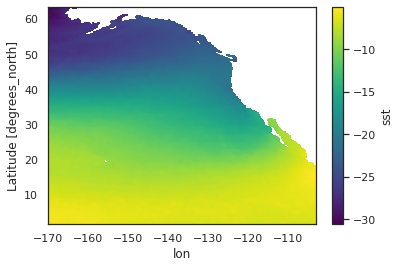

In [141]:
# Average Differences
(oisst_pnw.groupby('time.month').max('time').sst - specdata.Tmax).mean('month').plot()

In [164]:
(oisst_pnw.groupby('time.month').max('time').sst - specdata.Tmax)

<xarray.DataArray 'sst' (month: 12, lat: 248, lon: 268)>
dask.array<sub, shape=(12, 248, 268), dtype=float32, chunksize=(1, 50, 240), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 1.625 1.875 2.125 2.375 ... 62.875 63.125 63.375
  * lon      (lon) float32 -169.875 -169.625 -169.375 ... -103.375 -103.125
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [68]:
diffs = (grid - specdata.Tmax).mean('time').unstack('cell').compute()

NameError: name 'grid' is not defined

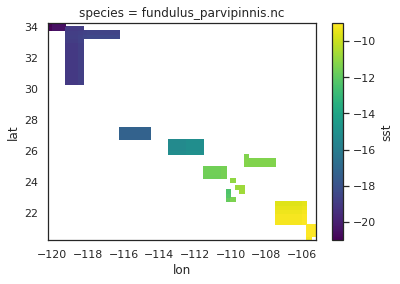

In [169]:
diffs.sst.T.plot()

(array([200., 354., 321., 272., 359., 182., 205.,  95.,  47.,   3.]),
 array([-21.136    , -20.0198   , -18.903599 , -17.7874   , -16.671198 ,
        -15.554998 , -14.438798 , -13.3225975, -12.206398 , -11.090198 ,
         -9.973997 ], dtype=float32),
 <a list of 10 Patch objects>)

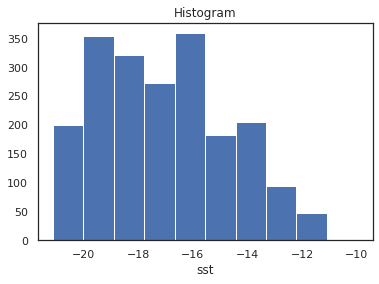

In [72]:
monthly_departures.plot.hist()